In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sgUmJcKajnsJigJKvbhR")
project = rf.workspace("machine-learning-4mojt").project("acl-and-pcl-detection")
version = project.version(1)
dataset = version.download("yolov11")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ACL-and-PCL-Detection-1 in yolov11:: 100%|██████████| 1946/1946 [00:00<00:00, 8650.64it/s]


In [2]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6170.1/8062.4 GB disk)


In [3]:
import os
import random
import shutil
from glob import glob

# Define dataset paths
dataset_path = "/kaggle/working/ACL-and-PCL-Detection-1"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# Create necessary folders if they don’t exist
for folder in [train_path, valid_path, test_path]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# Check if dataset is already split
if len(glob(os.path.join(valid_path, "images", "*.*"))) > 0 or len(glob(os.path.join(test_path, "images", "*.*"))) > 0:
    print("⚠️ Dataset has already been split. Skipping re-splitting!")
else:
    # Get all image paths (supporting multiple formats)
    image_paths = glob(os.path.join(train_path, "images", "*.*"))  # Handles jpg, png, jpeg
    random.shuffle(image_paths)  # Shuffle images for random split

    # Define split sizes
    total_images = len(image_paths)
    test_count = int(0.2 * total_images)
    valid_count = int(0.1 * total_images)

    # Move 20% of images to test set
    for img in image_paths[:test_count]:
        label = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.move(img, os.path.join(test_path, "images", os.path.basename(img)))
        if os.path.exists(label):
            shutil.move(label, os.path.join(test_path, "labels", os.path.basename(label)))

    # Move 10% of images to validation set
    for img in image_paths[test_count : test_count + valid_count]:
        label = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.move(img, os.path.join(valid_path, "images", os.path.basename(img)))
        if os.path.exists(label):
            shutil.move(label, os.path.join(valid_path, "labels", os.path.basename(label)))

    print("✅ Dataset split completed successfully!")

# Print dataset statistics
def count_images(folder):
    return len(glob(os.path.join(folder, "images", "*.*")))

print(f"Total images in train: {count_images(train_path)}")
print(f"Total images in valid: {count_images(valid_path)}")
print(f"Total images in test: {count_images(test_path)}")


✅ Dataset split completed successfully!
Total images in train: 679
Total images in valid: 97
Total images in test: 194


In [5]:
!yolo task=detect mode=train model=yolo11s.pt data=/kaggle/working/ACL-and-PCL-Detection-1/data.yaml epochs=60 imgsz=640 plots=True augment=True


100%|██████████████████████████████████████| 18.4M/18.4M [00:00<00:00, 46.0MB/s]
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/kaggle/working/ACL-and-PCL-Detection-1/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

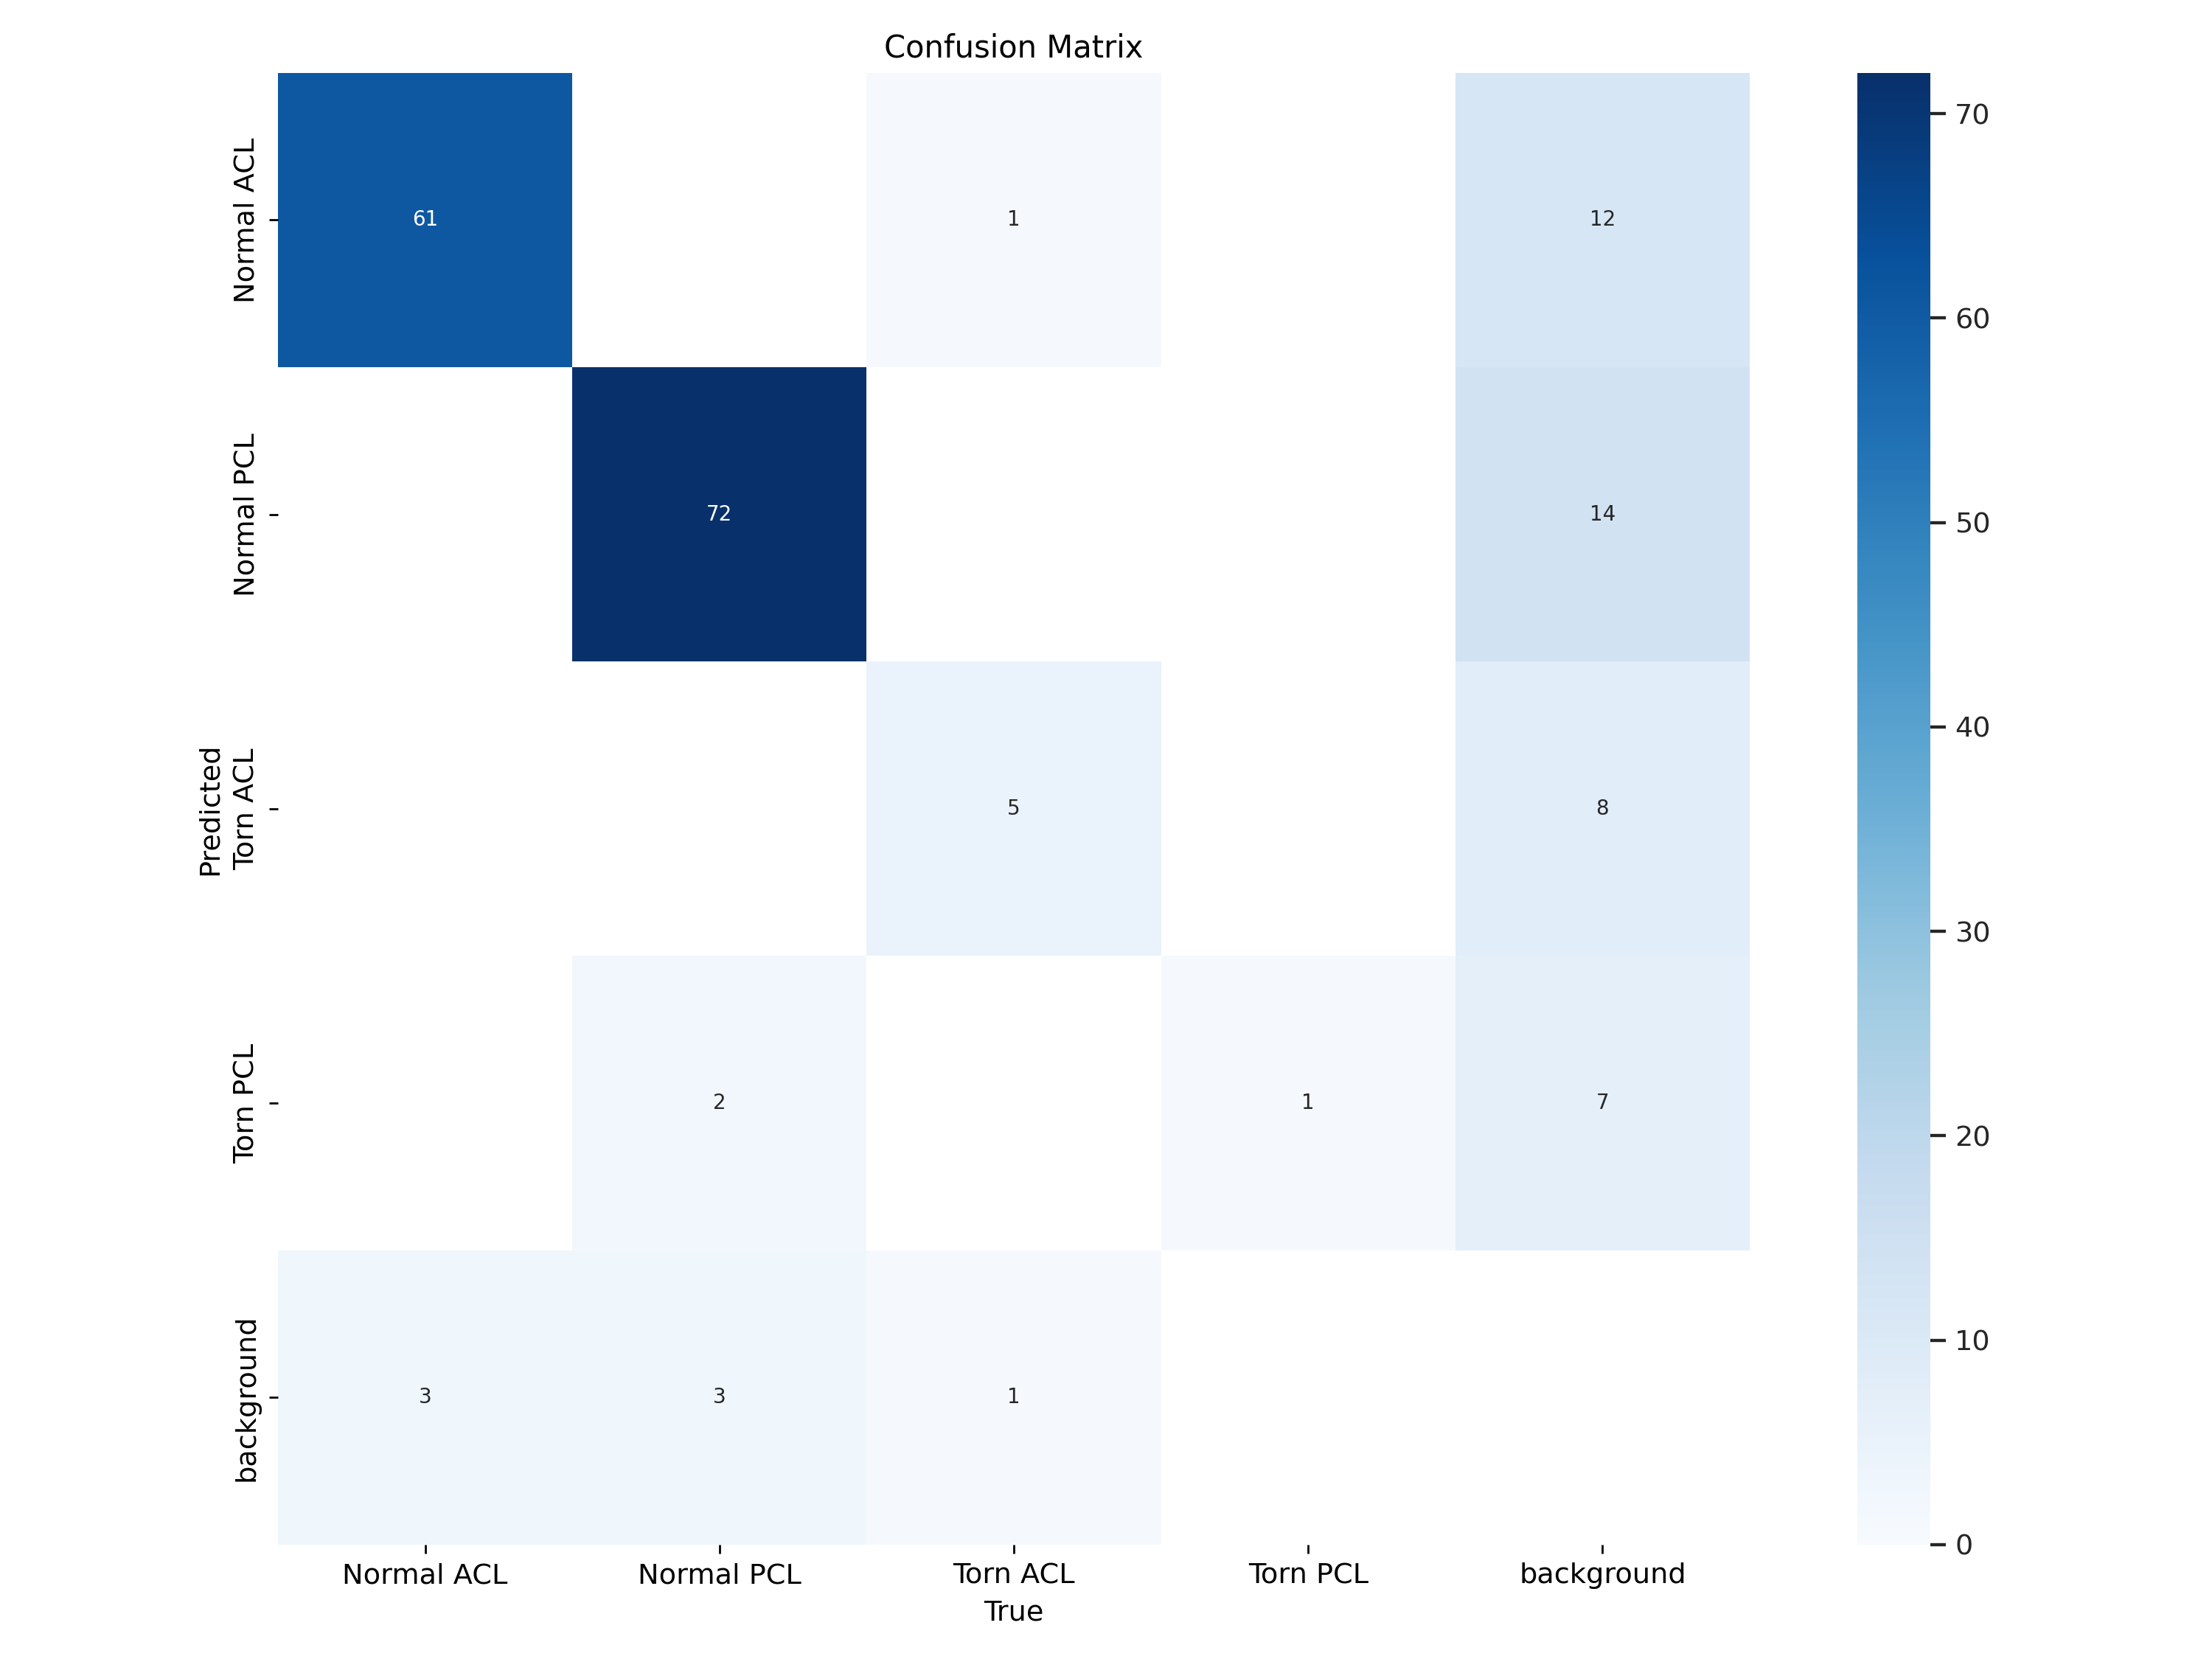

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/kaggle/working/runs/detect/train/confusion_matrix.png', width=600)

In [10]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.25 source=/kaggle/working/ACL-and-PCL-Detection-1/test/images save=True

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_107_jpg.rf.bc4d6c53a699704114cab19321ce0dc8.jpg: 640x640 1 Normal PCL, 11.0ms
image 2/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_108_jpg.rf.fe6cec9c4c570b8bd111b1f4cd7c27e9.jpg: 640x640 1 Normal PCL, 9.1ms
image 3/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_123_jpg.rf.df7b9501d7132e4d902aa65ca7b208c6.jpg: 640x640 1 Normal ACL, 1 Normal PCL, 1 Torn ACL, 9.0ms
image 4/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_125_jpg.rf.6a8910748cbfd0e3a84e72d75f7c8f0e.jpg: 640x640 1 Normal PCL, 9.1ms
image 5/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_130_jpg.rf.1fa894a6276965bc4f6eedf74fca7df9.jpg: 640x640 1 Normal PCL, 9.0ms
image 6/194 /kaggle/working/ACL-and-PCL-Dete

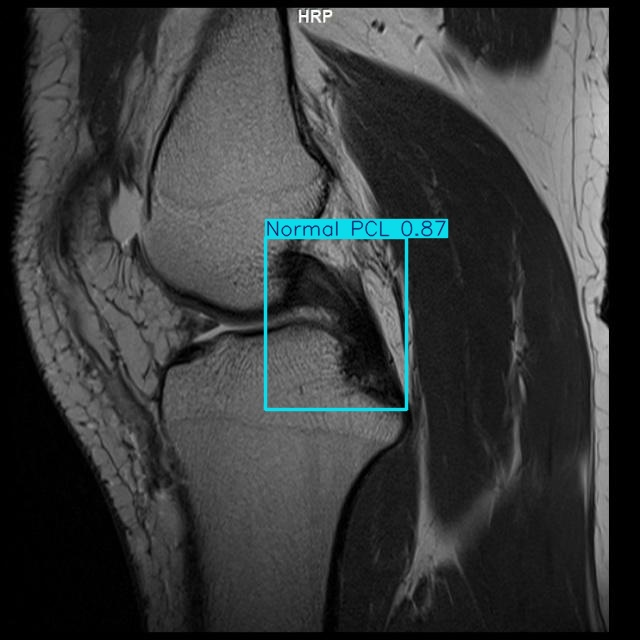

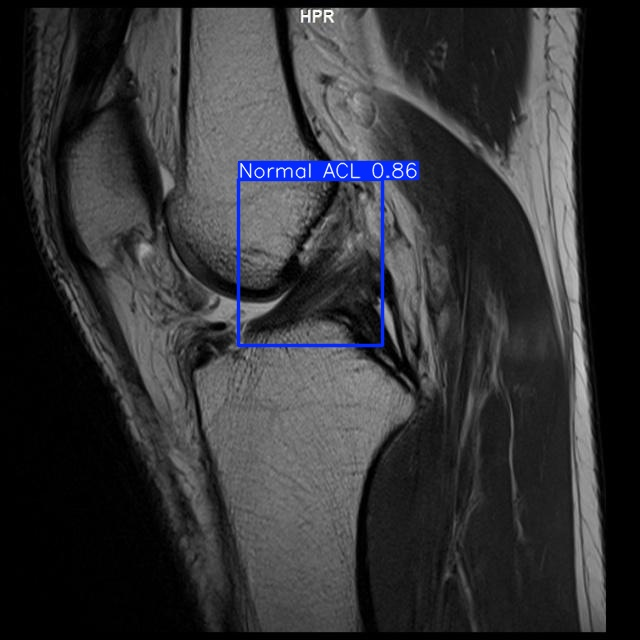

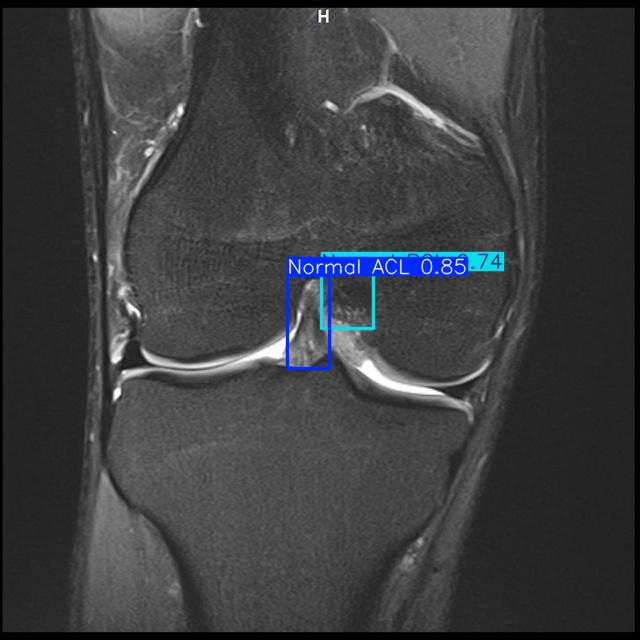

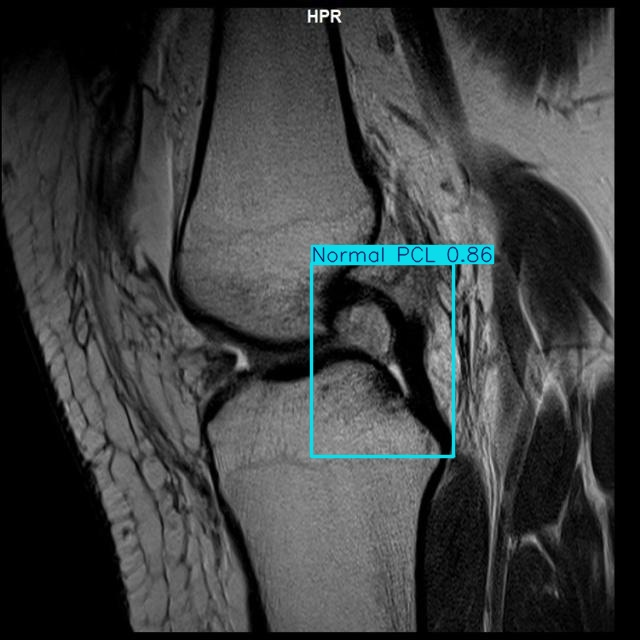

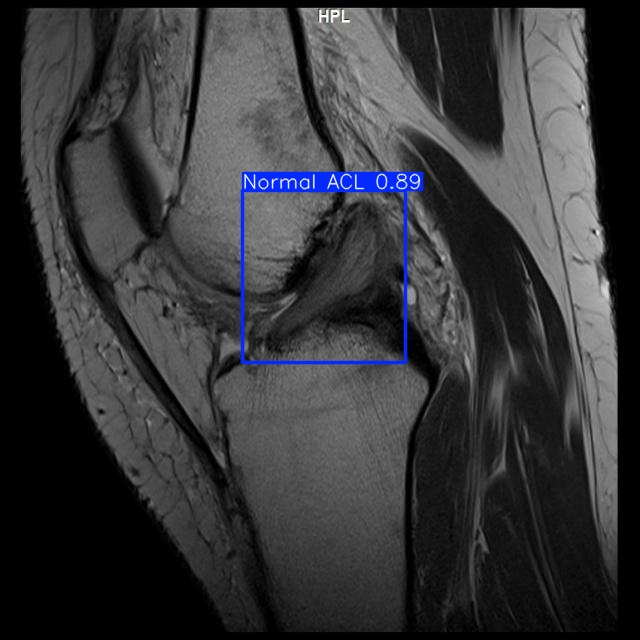

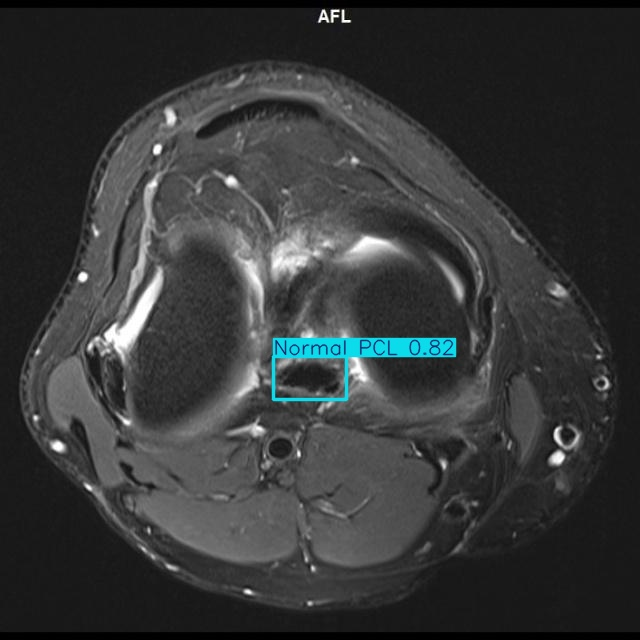

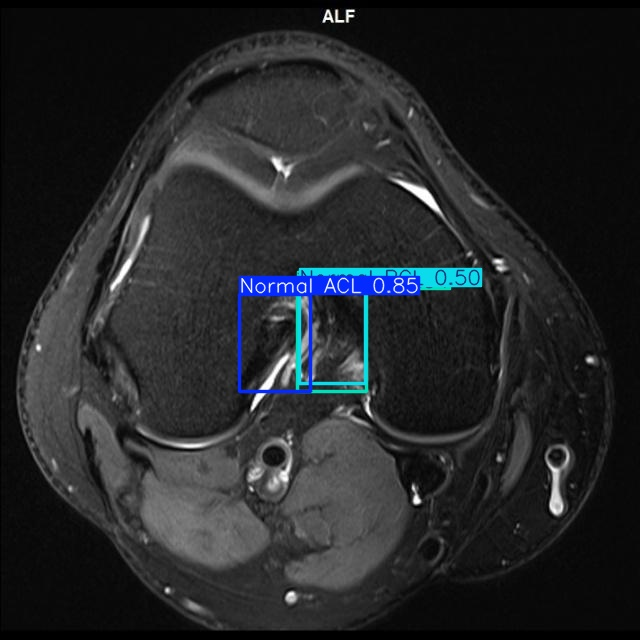

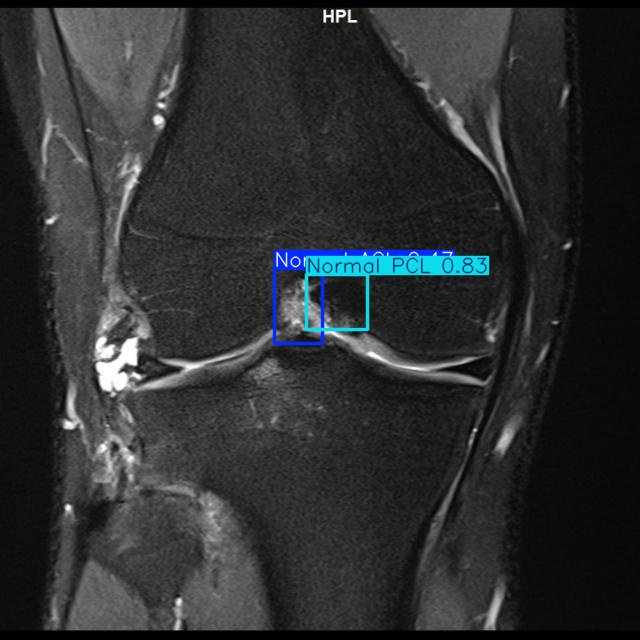

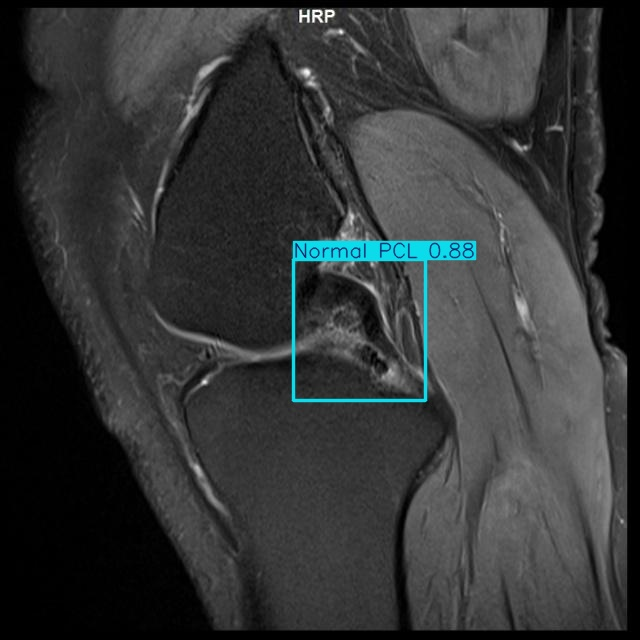

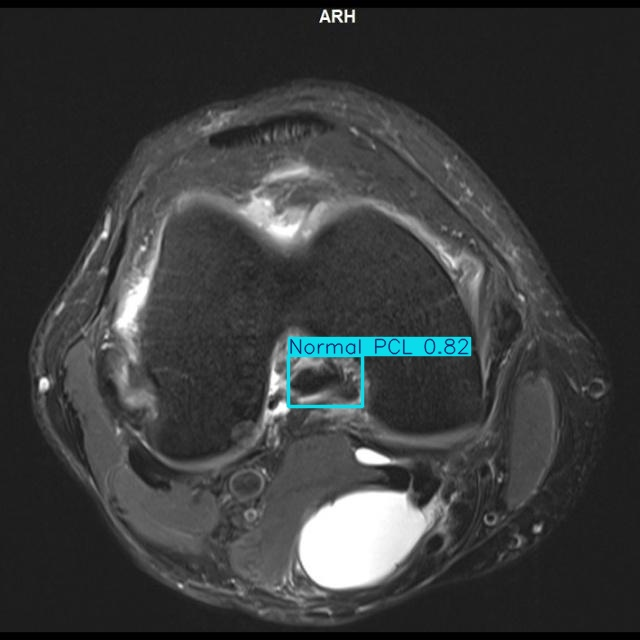

In [11]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/kaggle/working/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:10]:
	display(IPyImage(filename=img, width=600))
	print("\n")

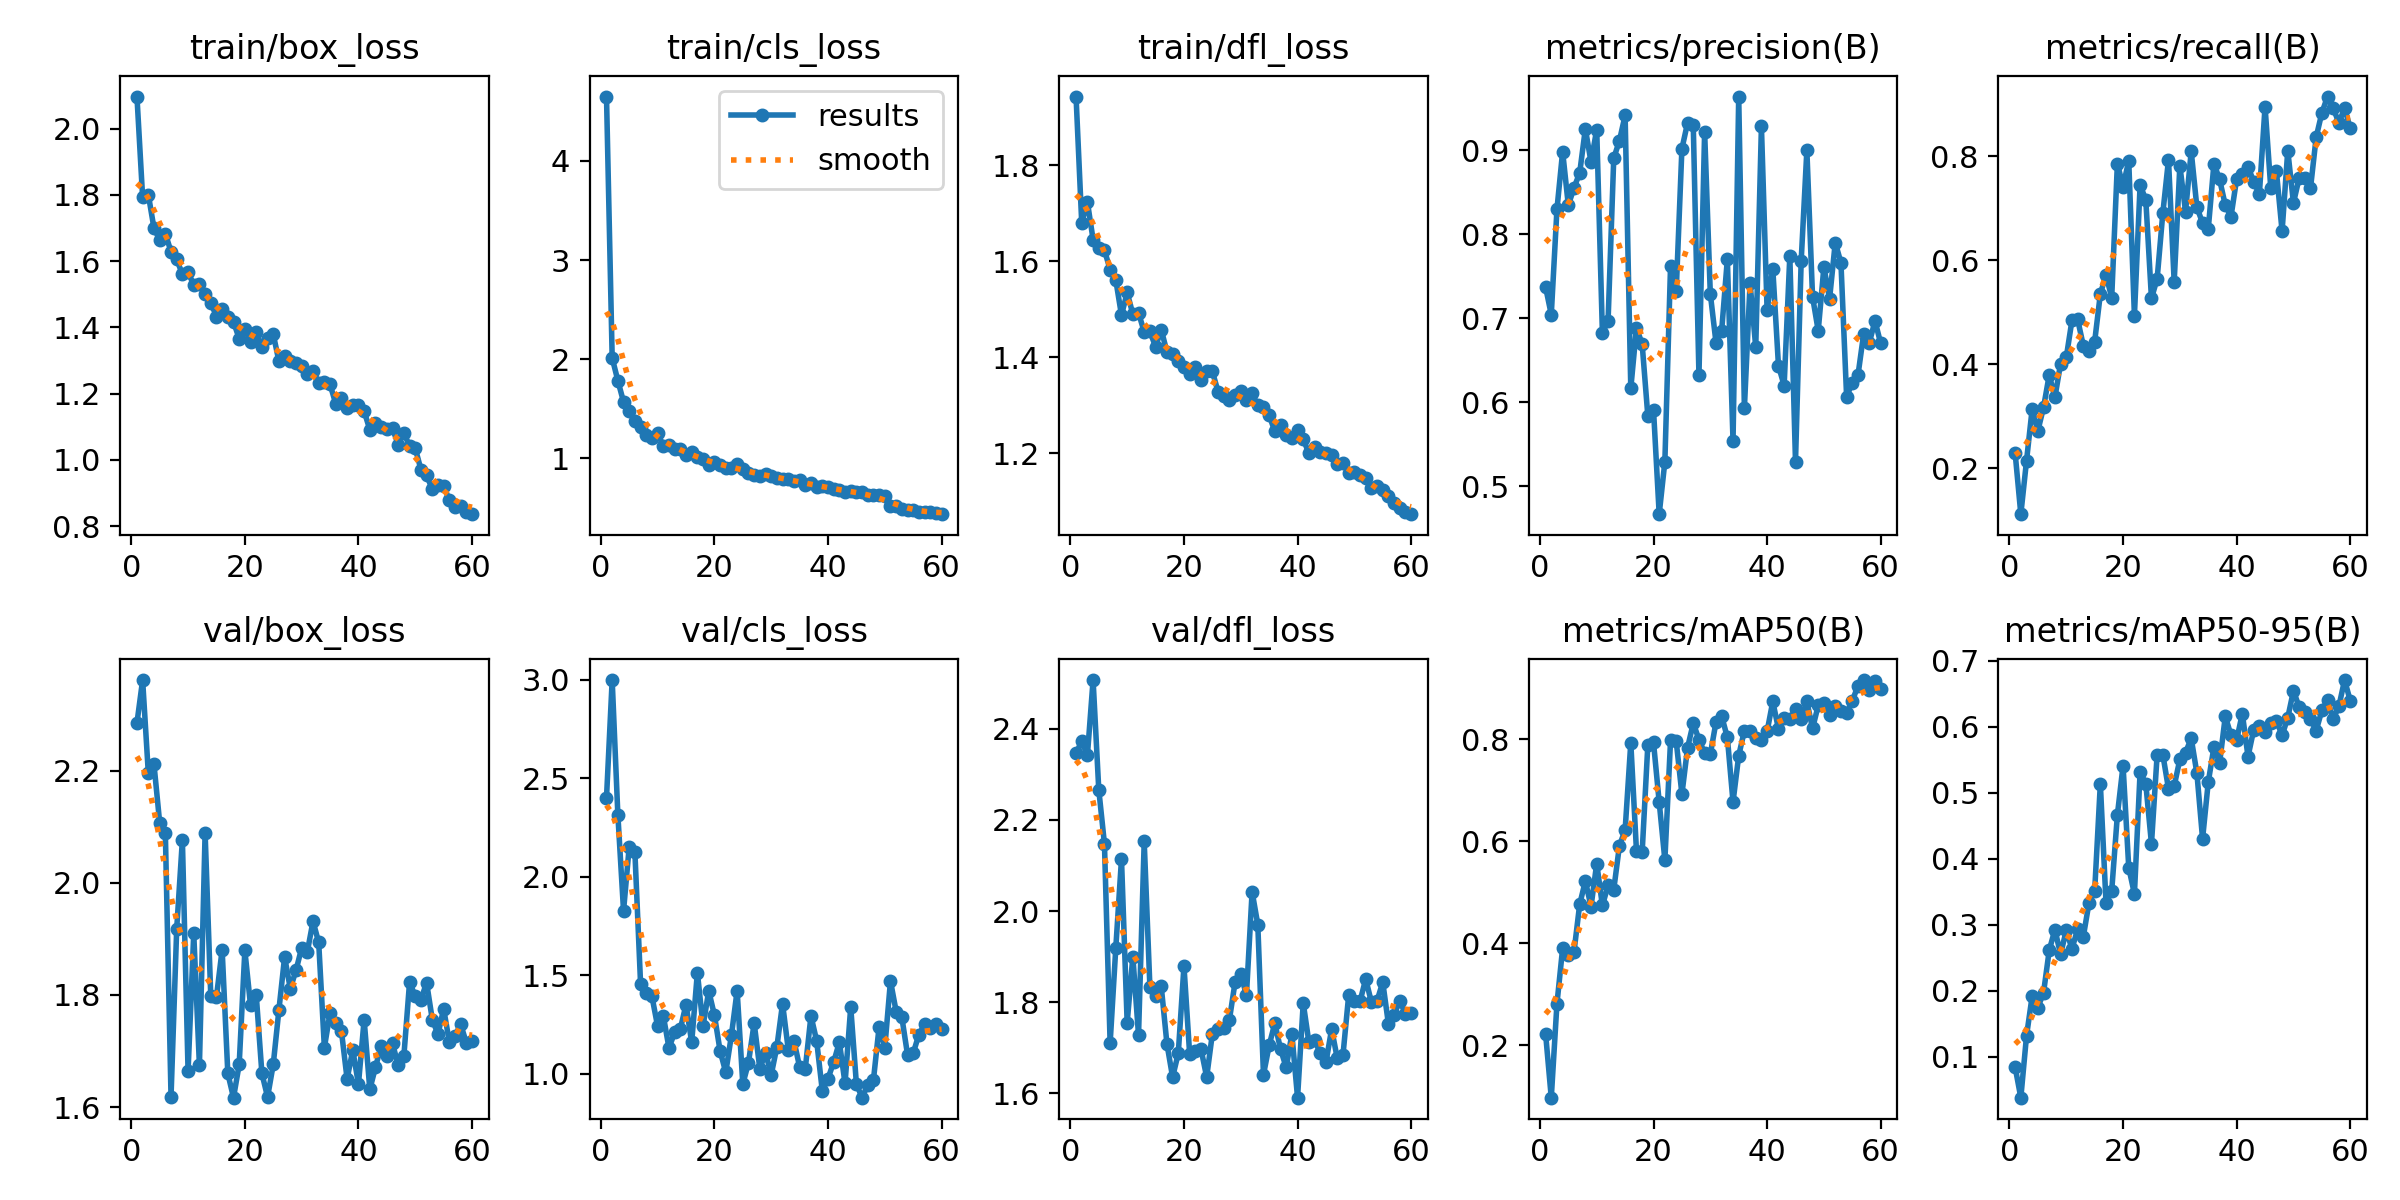

In [15]:
from IPython.display import Image as IPyImage

# Display training loss curves (accuracy, loss, and other metrics during training)
loss_curve_path = '/kaggle/working/runs/detect/train/results.png'
IPyImage(filename=loss_curve_path, width=600)


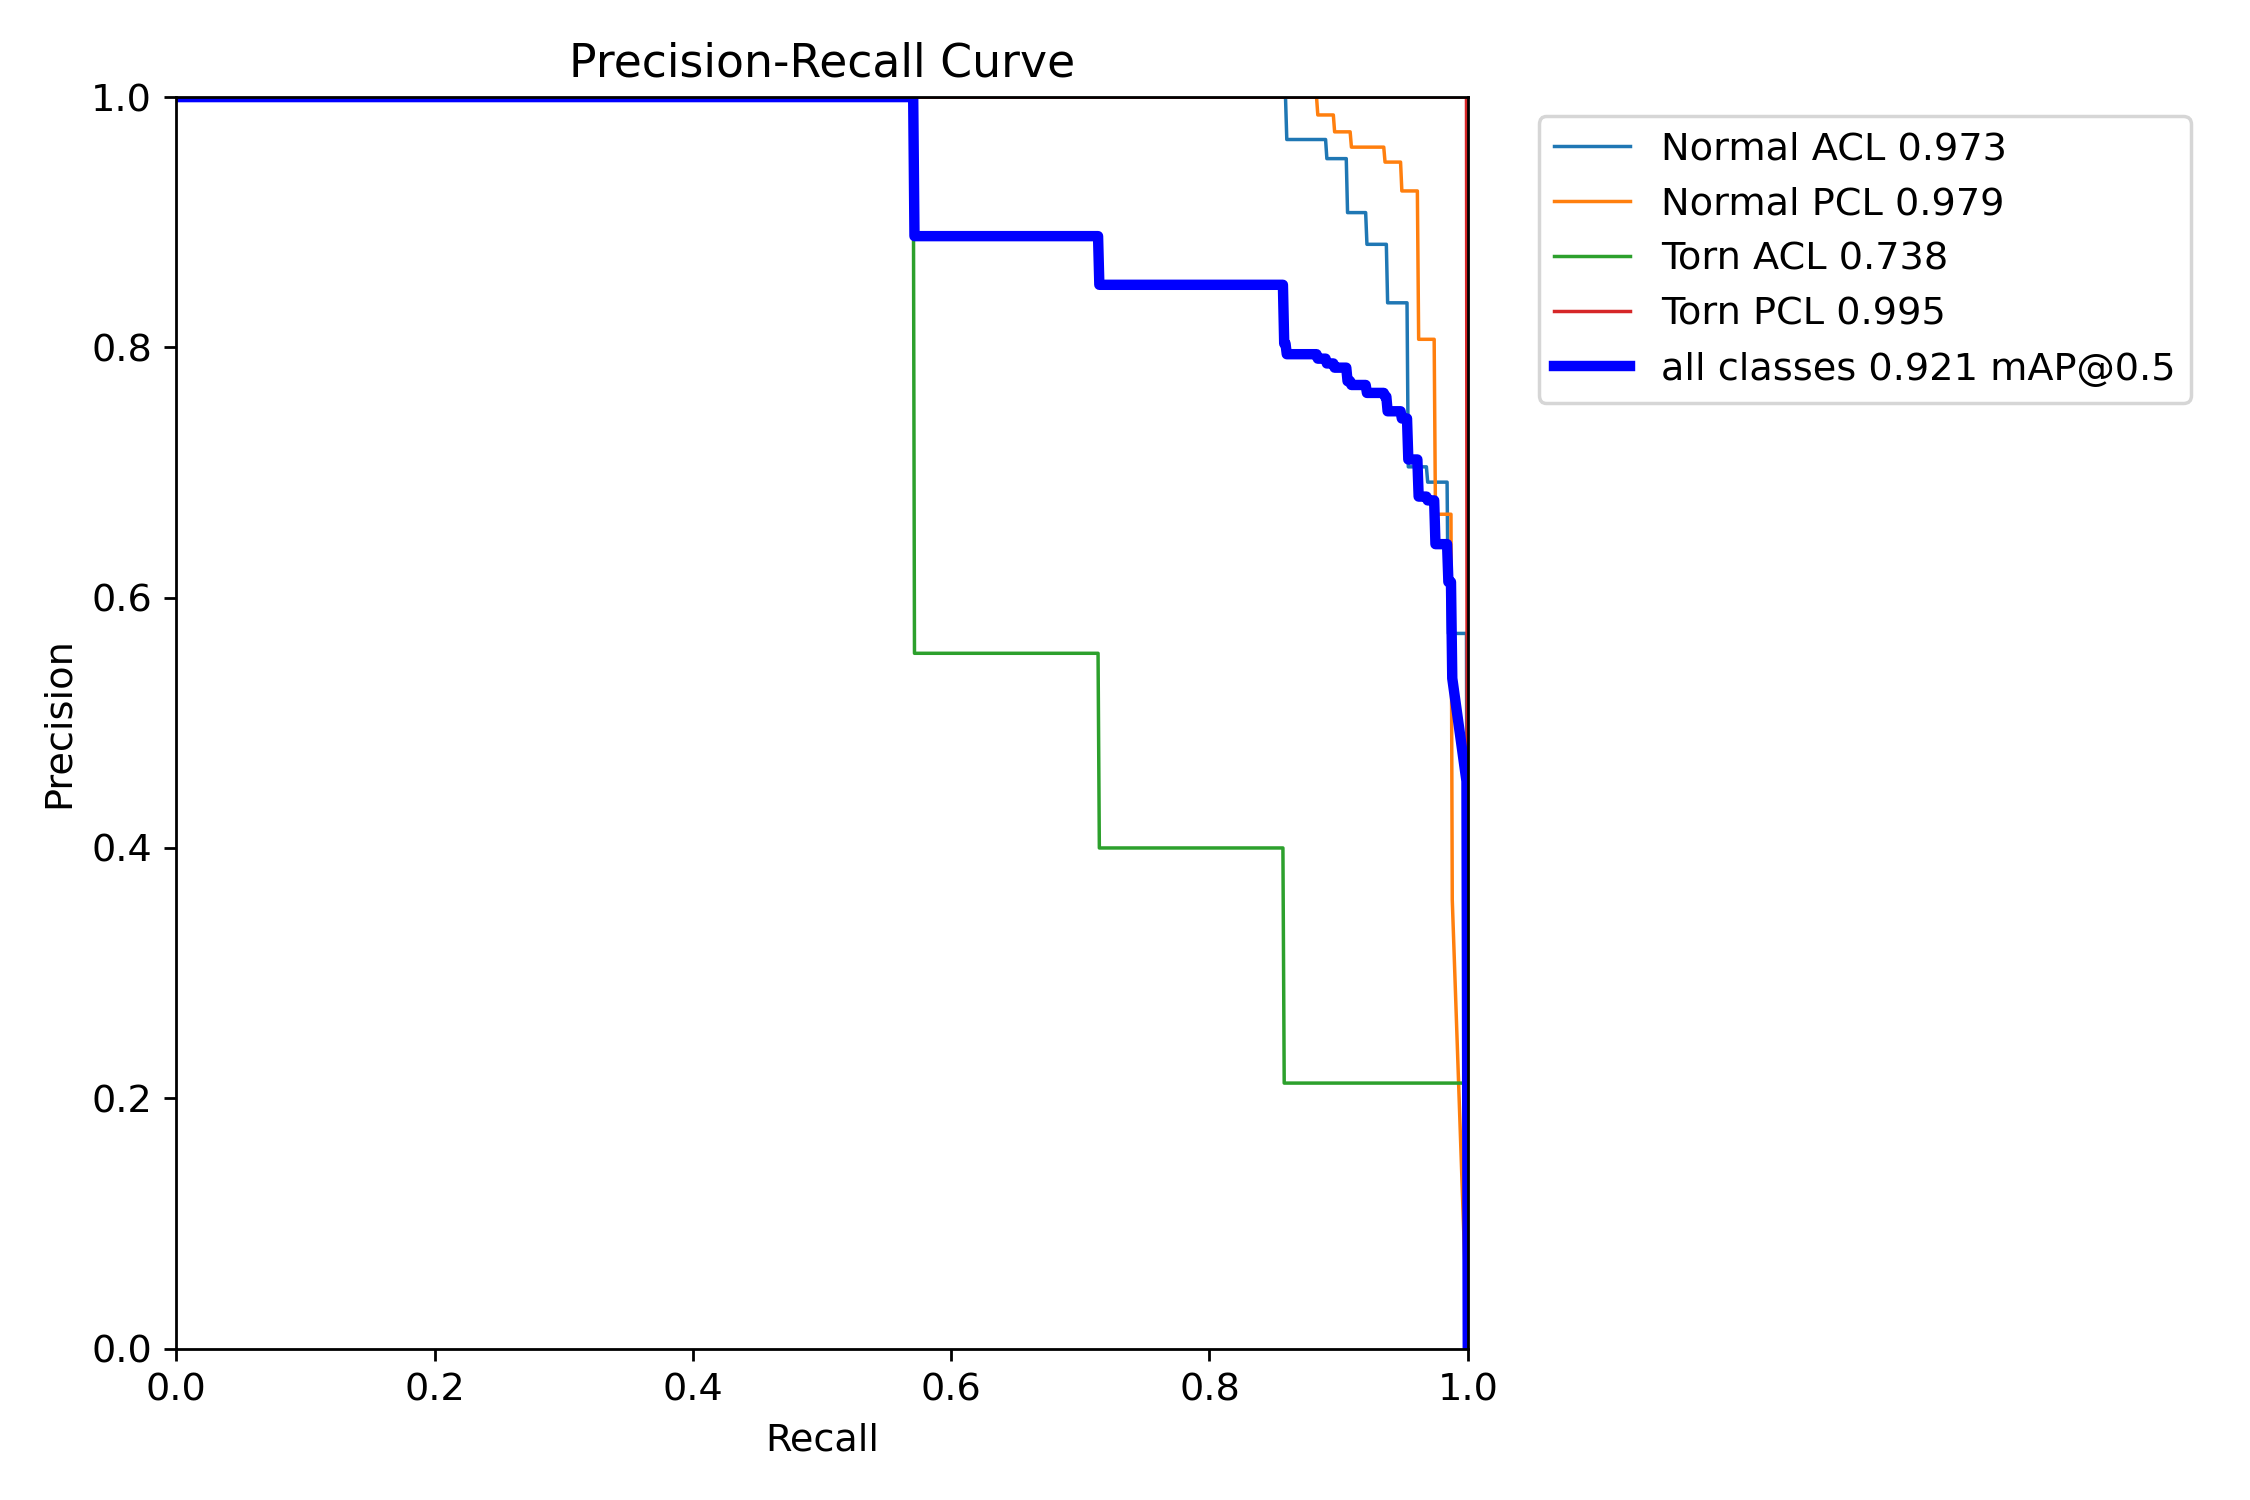

In [16]:
try:
    pr_curve_path = os.path.join("/kaggle/working/runs/detect/train/PR_curve.png")
    display(IPyImage(filename=pr_curve_path, width=800))
except FileNotFoundError:
    print(f"Precision-Recall curve image not found at: {pr_curve_path}")



In [8]:
import ultralytics
from ultralytics import YOLO
model = YOLO('/kaggle/working/yolo11s.pt')
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

In [23]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 118 (delta 15), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (118/118), 41.00 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [25]:
!ls

ACL-and-PCL-Detection-1  runs  yolo11n.pt  yolo11s.pt  YOLO-V8-CAM


In [26]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [27]:
!ls

images	     models	yolo_cam		 YOLO_v8n_EigenCAM.ipynb
LICENSE.txt  README.md	YOLO_v11_EigenCAM.ipynb


In [28]:
!pip install ttach

In [47]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [65]:
img = cv2.imread('/kaggle/working/ACL-and-PCL-Detection-1/test/images/sag_t2_47_jpg.rf.3a0320b57c66ff4ee7f1c772d12328f4.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [66]:
target_layer = model.model.model[23].cv3[2]  # Last Conv2d layer in cv3



0: 640x640 1 Normal PCL, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


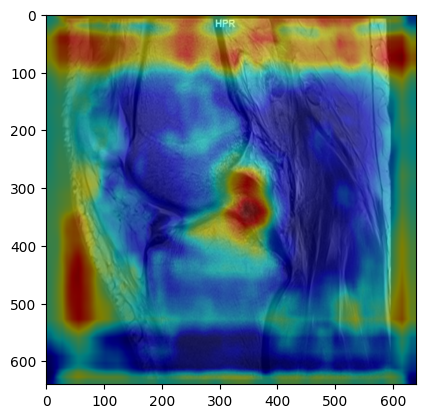

In [67]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

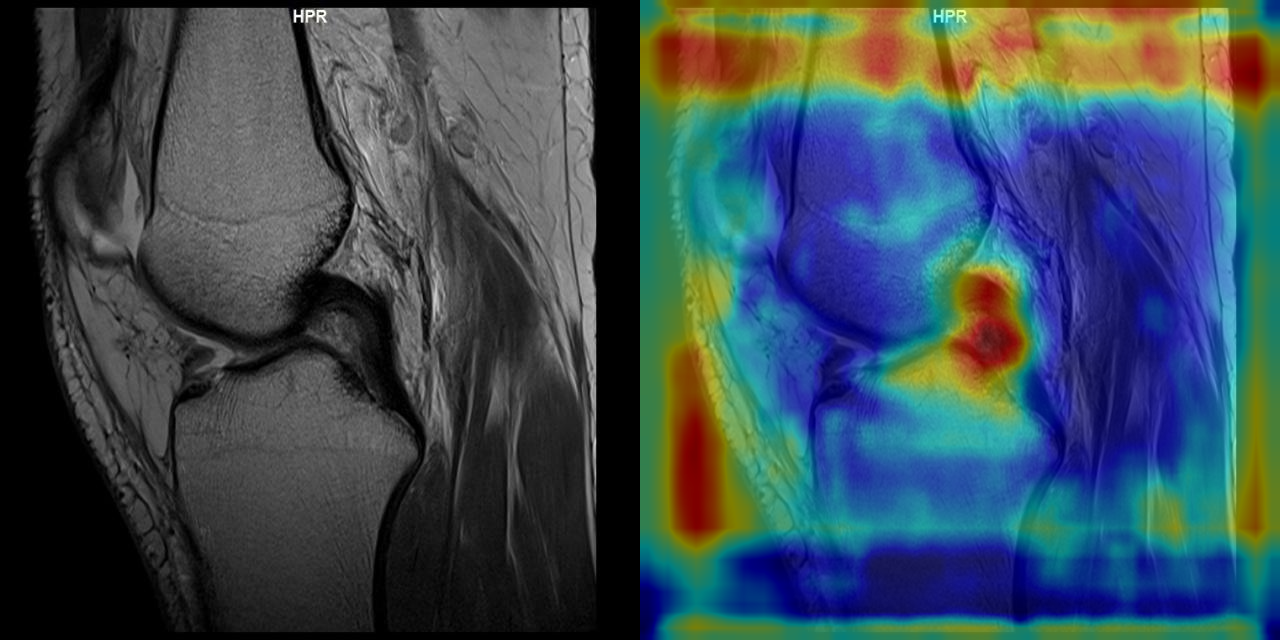

In [68]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))